<a href="https://colab.research.google.com/github/sashavlasits/Data-Science/blob/main/Unit6/SashVlasU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi
import bambi as bmb

##The Context

Penguins are, despite their lack of prowess at flying, one of the very best of the multitude of birds that reside on this planet. They are good at swimming, are highly resistent to cold temperatures, and sometimes have cool haircuts. They have beautiful bichromatic coloring, have a delightful philosophy about love, and are sometimes gay, which is interesting. This analysis will focus on predicting flipper length using a variety of factors. It will explore how much flipper length is affected by body mass, sex, and penguin species. This will be interesting and important because we will potentuially be able to predict flipper length for other groups of penguins if we know which factors have the most effect.  

##The Data

This data was sourced from Mr. Arredondo's github. It encompasses three flavors of penguin: Adelie, Gentoo, and Chinstrap, and includes data for various penguin physcial atrributes. I will be including bill length, sex, species, bill depth, flipper length, and body mass in my model. In terms of data wrangling, I only had to remove the rows where values were missing.

In [3]:
url_penguin = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/penguins.csv'
penguin = pd.read_csv(url_penguin,dtype={'species':'category'})
penguin

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [4]:
pyay = penguin.dropna()
pyay

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


##The Pair Plot

This pair plot is showing some pretty great positive correlations between my variables. Some of the best correlations are between body mass and flipper length as well as body mass and beak length. Some of the graphs have two or more large groupings of data, which suggests to me some difference between penguin sex or species where male penguins have larger beaks than females, or some other such trend. None of the graphs look obviously random and bad, so I will be including all of the variables to start and paring them down if needed.

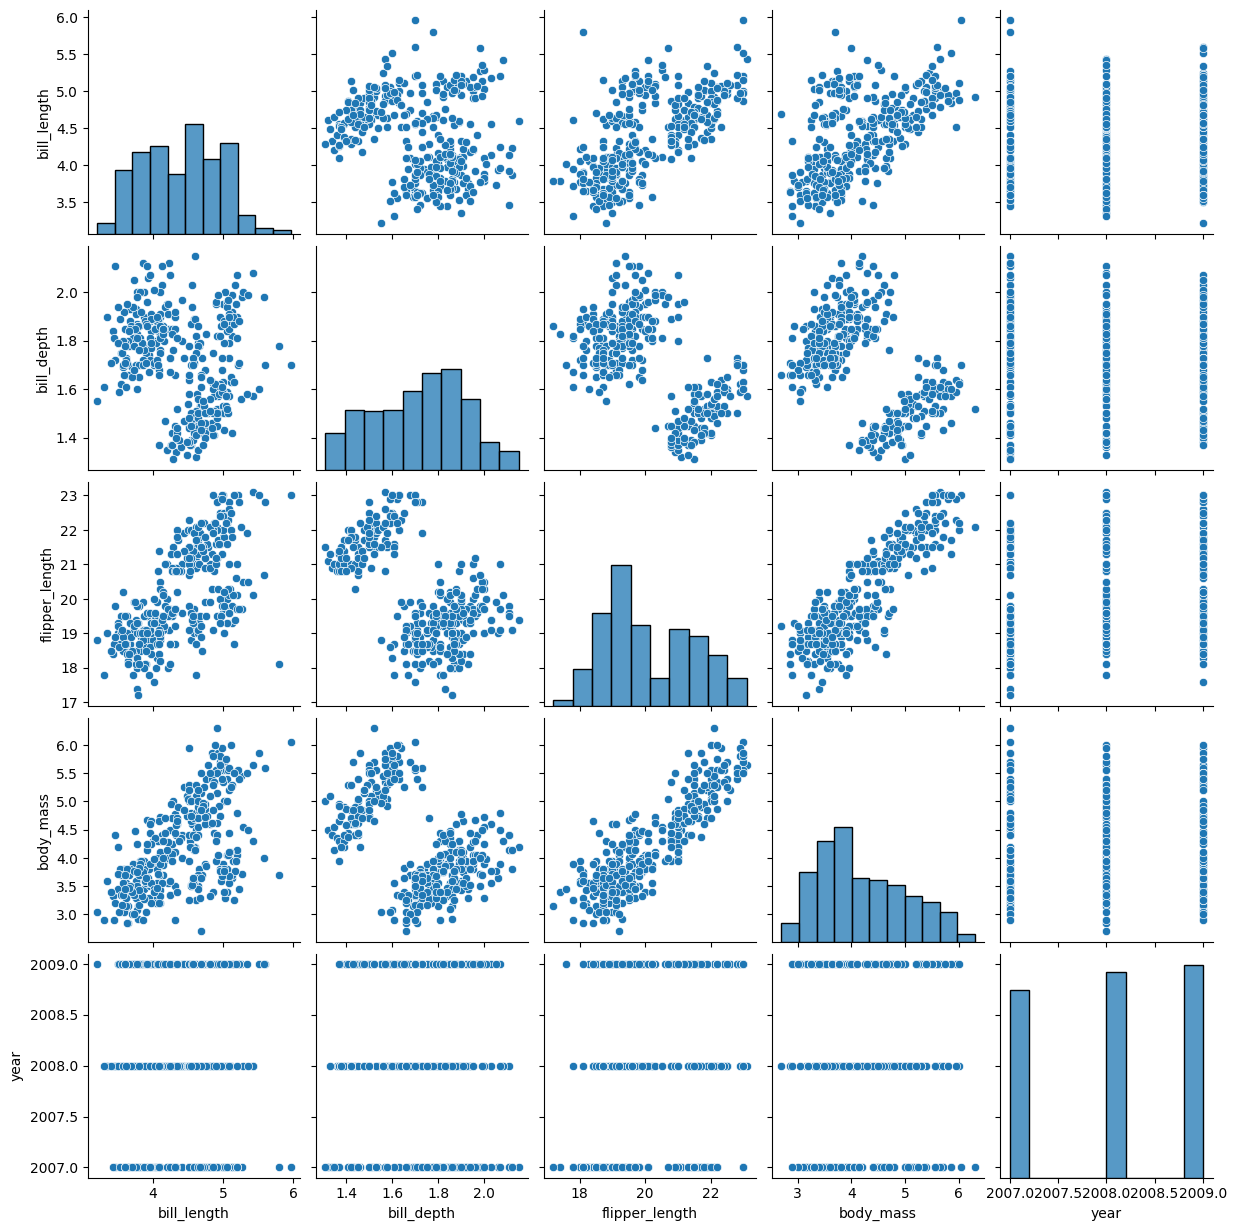

In [ ]:
sns.pairplot(pyay)

##The Causal Diagram

This tangled mess of yarn actually does have some meaning, I promise. I decided, after drawing the diagram out, to try and predict body mass because it was connected to all of the variables and I though that all of the other variables had a causal relationship. I think that they wil all have singular directional arrows. A larger penguin seems like it would cause larger flippers and beaks. I also assume that there is sexual dimorphism in penguins that would cause them to be different sizes, and that there is size varience between pengiun species. Since I don't know a vast amount about penguins, I'm going to assume that beak measurements have a negligible effect on flipper size, so I will disregard them in my model.

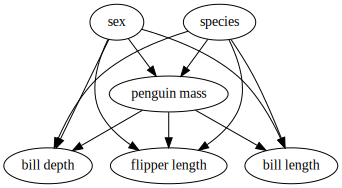

In [ ]:
dag_b = gv.Digraph(comment='bikes_dag') #b for bikes

dag_b.node('F', 'flipper length')
dag_b.node('P', 'penguin mass')
dag_b.node('G', 'sex')
dag_b.node('S', 'species')
dag_b.node('D','bill depth')
dag_b.node('B','bill length')

dag_b.edges(['SP', 'GP', 'SB', 'SF','SD','GB','GF','GD','PD','PB','PF'])



dag_b

##Model 1

This model includes all of the variables that I said could have causality with flipper length. I made heirarchies with body mass and sex as well as body mass and species, as I thought that there was an additional effect there. The posterior predictive check shows that this model worked pretty well! So that's great. But we must try again.

In [ ]:
#define the model
model_salmonsnack = bmb.Model("`flipper_length` ~ `body_mass` + (`body_mass`|`sex`) + `body_mass` + (`body_mass`|`species`) + `body_mass` + `sex` + `species`", data=pyay)
#fit the model
idata_salmonsnack = model_salmonsnack.fit(idata_kwargs={'log_likelihood': True})

<Axes: xlabel='flipper_length'>

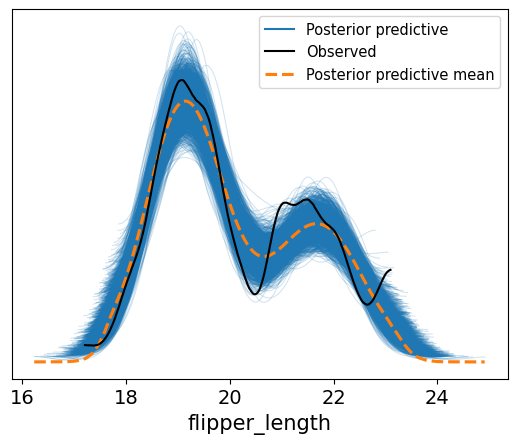

In [ ]:
model_salmonsnack.predict(idata_salmonsnack, kind="response")
az.plot_ppc(idata_salmonsnack)

##Model 2
Now we're going to pare down those variables. First, I shall remove the heirarchies and just look at the direct effects of the variables to see if the heirarchies were overcomplicating the whole thing. Honestly, based on the posterior predictive check, this looks virtually the same as the last one. But still we carry on in this data science crusade.

In [ ]:
#define the model
model_salmonsnack2 = bmb.Model("`flipper_length` ~ `body_mass` + `sex` + `species`", data=pyay)
#fit the model
idata_salmonsnack2 = model_salmonsnack2.fit(idata_kwargs={'log_likelihood': True})

<Axes: xlabel='flipper_length'>

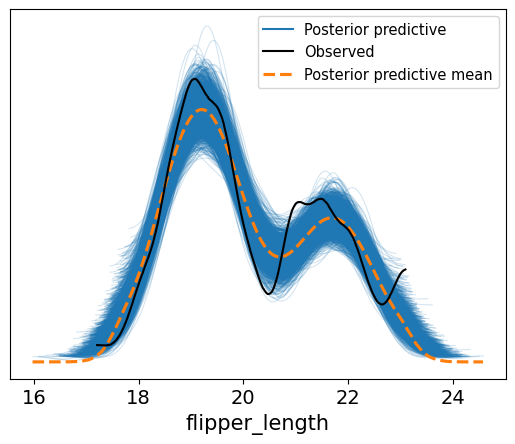

In [ ]:
model_salmonsnack2.predict(idata_salmonsnack2, kind="response")
az.plot_ppc(idata_salmonsnack2)

##Model 3
This time we're going super simple. Just body mass, as that seem to me like the clearest indicator of a larger flipper. So that was bad. Much much worse. Horrendus, really. Clearly sex and species have an important effect here.

In [ ]:
#define the model
model_salmonsnack3 = bmb.Model("`flipper_length` ~ `body_mass`", data=pyay)
#fit the model
idata_salmonsnack3 = model_salmonsnack3.fit(idata_kwargs={'log_likelihood': True})

<Axes: xlabel='flipper_length'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


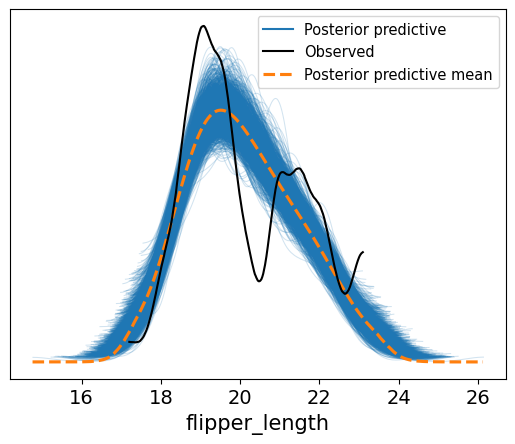

In [ ]:
model_salmonsnack3.predict(idata_salmonsnack3, kind="response")
az.plot_ppc(idata_salmonsnack3)

##Model 4

Now I shall try to isolate to see if it is sex or species (or both) that has the important effect on flipper length. So, I made this model with just sex. The result is bad, so I'm going to assume that species is also important. From the bambi interpreting plot we can see that there isn't much difference in the lines for male and female penguins.

In [ ]:
#define the model
model_salmonsnack4 = bmb.Model("`flipper_length` ~ `body_mass` + (`body_mass`|`sex`)  + `body_mass` + `sex`", data=pyay)
#fit the model
idata_salmonsnack4 = model_salmonsnack4.fit(idata_kwargs={'log_likelihood': True})

<Axes: xlabel='flipper_length'>

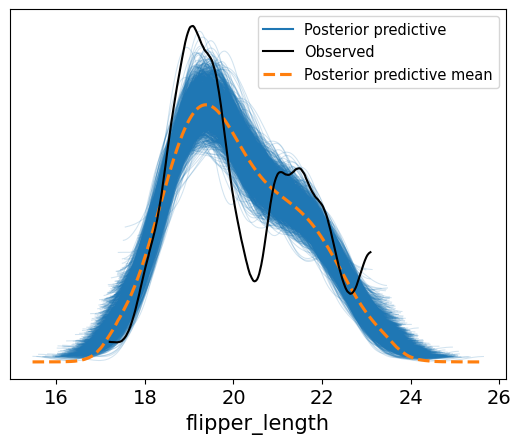

In [ ]:
model_salmonsnack4.predict(idata_salmonsnack4, kind="response")
az.plot_ppc(idata_salmonsnack4)

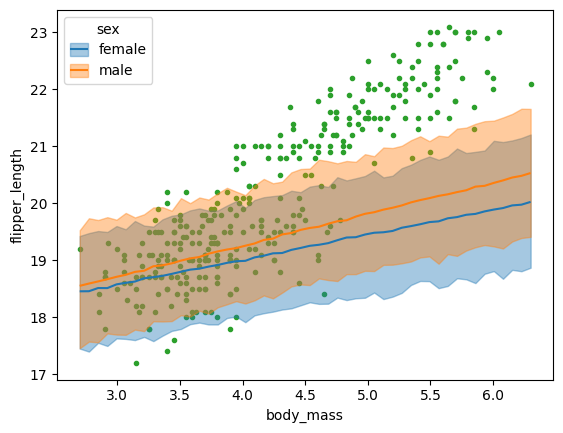

In [24]:
bmb.interpret.plot_predictions(model_salmonsnack, idata_salmonsnack, ["body_mass","sex"], pps=True)
plt.plot(pyay.body_mass, pyay.flipper_length, "C2.", zorder=-3)

##Model 5

Here I isolate just the speices hierarchy, along with body mass which I'm treating as a constant here. Based on this model it appears that the species has a much greater causal affect on flipper length, which makes sense given that there is likely more overall size varience among different species than between males and females of the same species. The bambi plot compare graph shows more difference in the slopes and intercepts of the lines for each species than for sex, which is cool.

In [ ]:
#define the model
model_salmonsnack5 = bmb.Model("`flipper_length` ~ `body_mass` + (`body_mass`|`species`)  + `body_mass` + `species`", data=pyay)
#fit the model
idata_salmonsnack5 = model_salmonsnack5.fit(idata_kwargs={'log_likelihood': True})

<Axes: xlabel='flipper_length'>

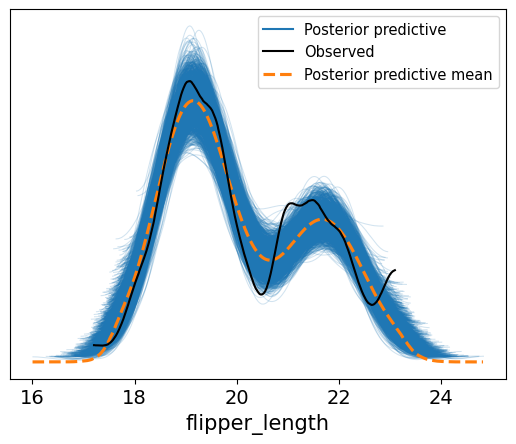

In [6]:
model_salmonsnack5.predict(idata_salmonsnack5, kind="response")
az.plot_ppc(idata_salmonsnack5)

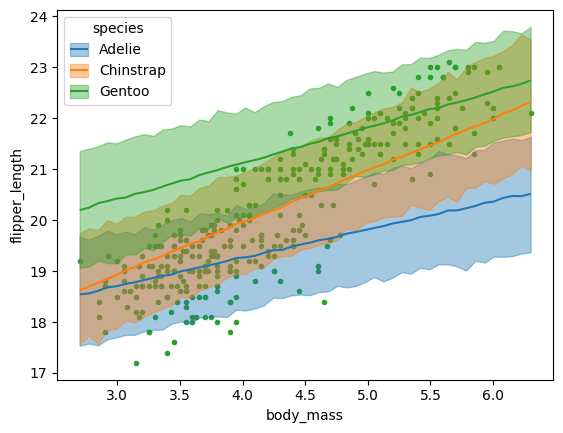

In [23]:
bmb.interpret.plot_predictions(model_salmonsnack, idata_salmonsnack, ["body_mass","species"], pps=True)
plt.plot(pyay.body_mass, pyay.flipper_length, "C2.", zorder=-3)

##The Comparison

These results show pretty much what I would have predicted just given the posterior predictive chech graphs. The one with the most variables included is the best (model 1), but not by a lot. This makes sense, as all of the variable seem like pretty clear predictors of flipper length given the penguin context. The graph with all the variables but not heirarchies (model 2) and the one that just has body mass and species (model 5) are similarly good. The other ones are trash. From this I can conclude that species has a very important effect as well as body mass, but penguin sex has a pretty negligible effect. This makes sense from the posterior predictive graphs which shows two humps of data. I imagine that the larger hump has the data for two of the speices and the smaller one has the data for the other, larger species.

In [14]:
cmp_df = az.compare( {"all variables with heirarchies":idata_salmonsnack,"all variables no heirarchies":idata_salmonsnack2, "just body mass":idata_salmonsnack3, "body mass and sex":idata_salmonsnack4, "body mass and species":idata_salmonsnack5} )

cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
all variables with heirarchies,0,-264.488021,7.955587,0.000000,9.188855e-01,13.972886,0.000000,False,log
all variables no heirarchies,1,-267.476146,5.871744,2.988125,5.675450e-02,13.712661,2.852725,False,log
body mass and species,2,-268.698968,6.993410,4.210948,4.046441e-14,13.886132,2.680587,False,log
body mass and sex,3,-337.873367,4.294762,73.385346,5.112470e-14,12.205873,10.936391,False,log
just body mass,4,-348.129382,2.658403,83.641361,2.436004e-02,12.544947,12.051162,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

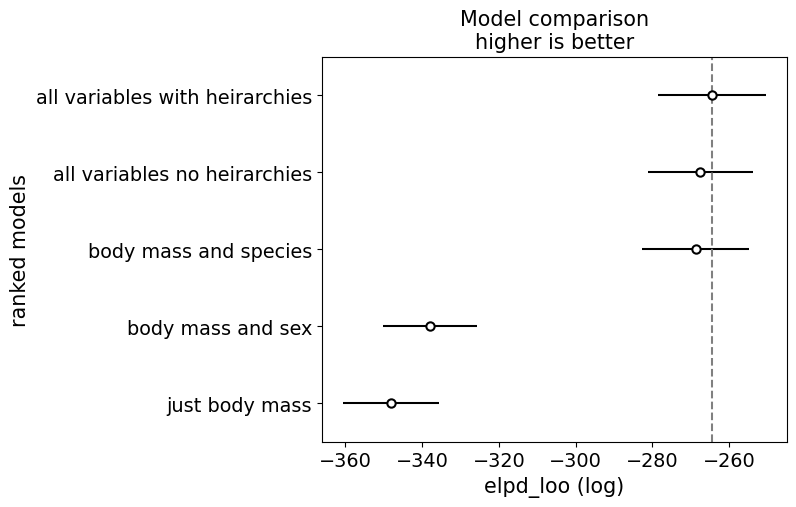

In [15]:
az.plot_compare(cmp_df)

##The Conclusion

The first model is the best! But basically any model that includes both speices and body mass does the job. Also, penguins are so cute!

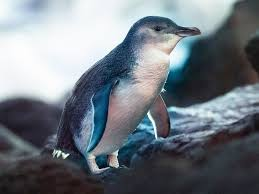